In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q torch

In [3]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
# For VS Code & PyCharm
#pip install torch_scatter
#pip install torch_sparse

In [4]:
from torch_geometric.datasets import Planetoid


In [5]:
from torch_geometric.transforms import NormalizeFeatures

In [6]:
dataset = Planetoid(root = "/content/drive/MyDrive/Urgent/Planetoid", name = 'Cora', transform = NormalizeFeatures())

In [7]:
dataset

Cora()

In [8]:
print(f"Dataset: {dataset}:")

Dataset: Cora():


In [9]:
print(f"Number of Graphs: {len(dataset)}")

Number of Graphs: 1


In [10]:
print(f"Number of feature: {dataset.num_features}")

Number of feature: 1433


In [11]:
print(f"Number of classes: {dataset.num_classes}")

Number of classes: 7


In [12]:
data = dataset[0]
data


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [14]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_features)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels = 16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 1433)
)


In [15]:
# Visualizing Untrained GCN network
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

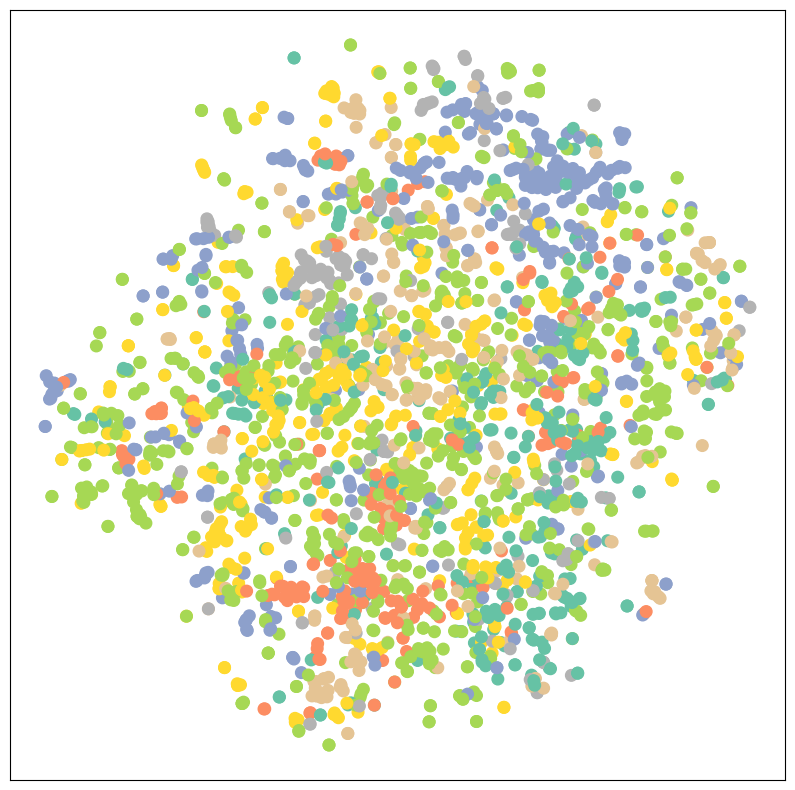

In [17]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color = data.y)

In [18]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

for epoch in range(1,101):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss: .4f}')

Epoch: 001, Loss:  7.2676
Epoch: 002, Loss:  7.2461
Epoch: 003, Loss:  7.2235
Epoch: 004, Loss:  7.1980
Epoch: 005, Loss:  7.1701
Epoch: 006, Loss:  7.1391
Epoch: 007, Loss:  7.1050
Epoch: 008, Loss:  7.0657
Epoch: 009, Loss:  7.0208
Epoch: 010, Loss:  6.9750
Epoch: 011, Loss:  6.9191
Epoch: 012, Loss:  6.8535
Epoch: 013, Loss:  6.7946
Epoch: 014, Loss:  6.7181
Epoch: 015, Loss:  6.6273
Epoch: 016, Loss:  6.5273
Epoch: 017, Loss:  6.4478
Epoch: 018, Loss:  6.3464
Epoch: 019, Loss:  6.2363
Epoch: 020, Loss:  6.0761
Epoch: 021, Loss:  5.9842
Epoch: 022, Loss:  5.8566
Epoch: 023, Loss:  5.7001
Epoch: 024, Loss:  5.5456
Epoch: 025, Loss:  5.3503
Epoch: 026, Loss:  5.1798
Epoch: 027, Loss:  4.9742
Epoch: 028, Loss:  4.8354
Epoch: 029, Loss:  4.6379
Epoch: 030, Loss:  4.4759
Epoch: 031, Loss:  4.1895
Epoch: 032, Loss:  4.0844
Epoch: 033, Loss:  3.7873
Epoch: 034, Loss:  3.6092
Epoch: 035, Loss:  3.4776
Epoch: 036, Loss:  3.1232
Epoch: 037, Loss:  3.0370
Epoch: 038, Loss:  2.9358
Epoch: 039, 

In [19]:
test_acc = test()

In [20]:
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.1300


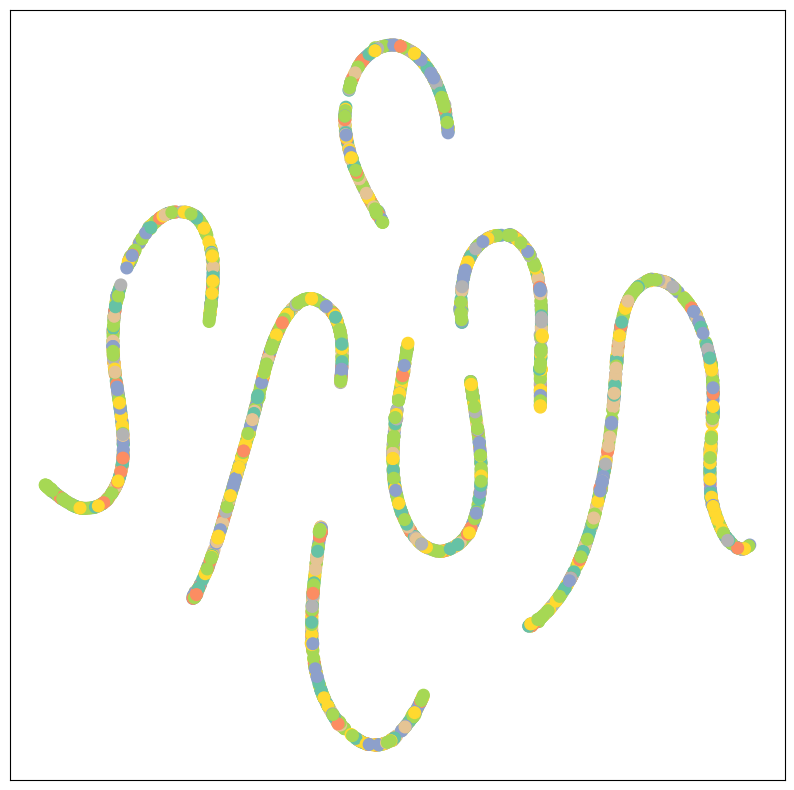

In [21]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [22]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

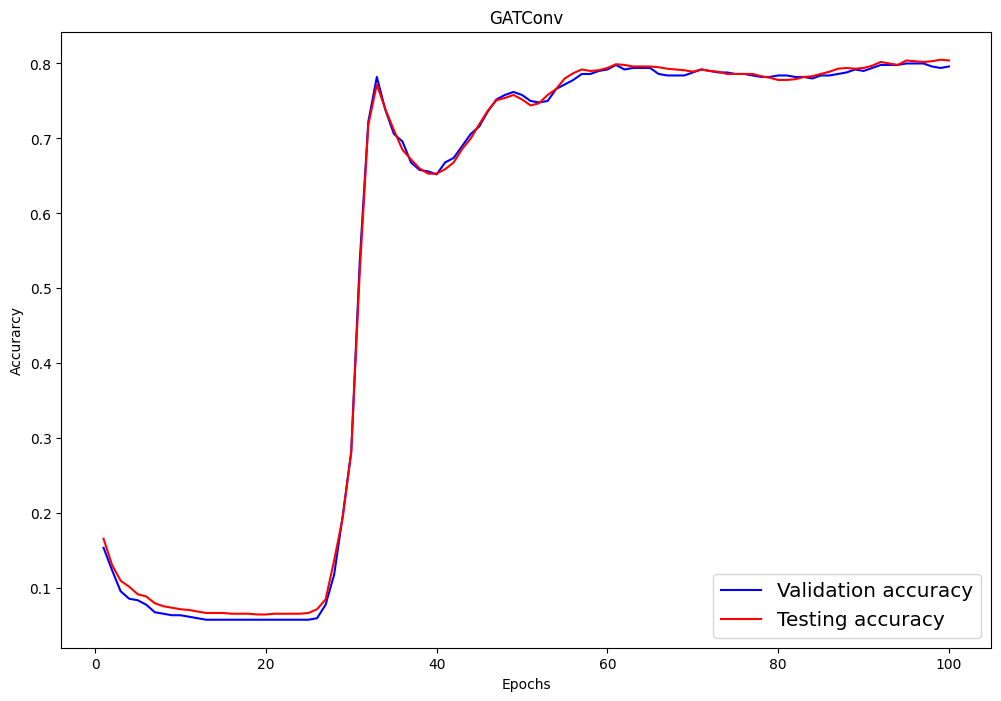

In [23]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

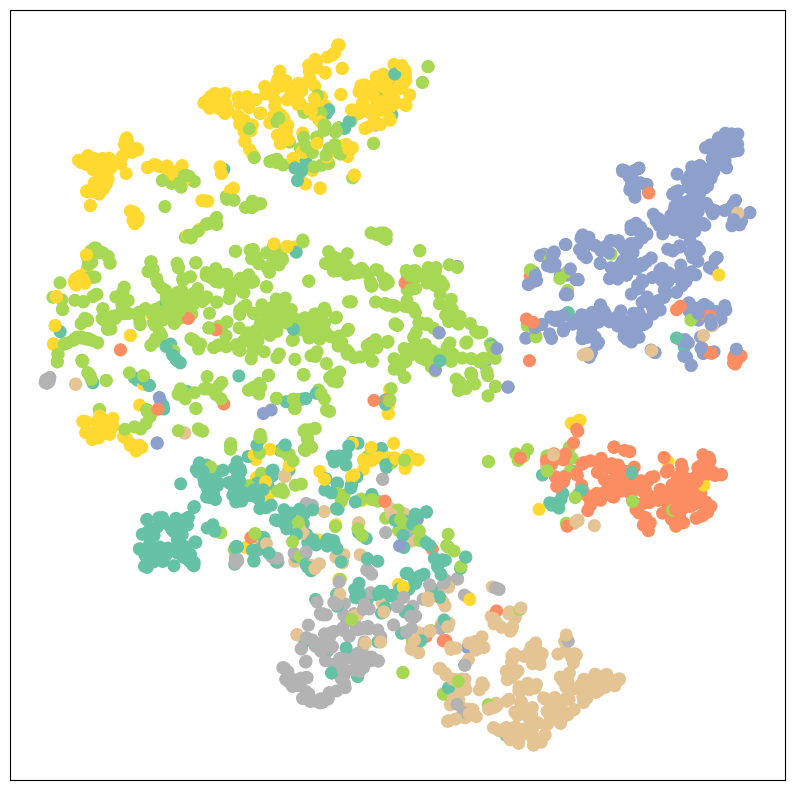

In [24]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)